## Comparison to "diptest" 

This package is specifically Python2 and NOT python3 compatible. I was unable to edit and include the code with this project because it is GPL licensed, which requires everything that remixes the code to also be GPL, but this is BSD licensed which doesn't require everything to also have be BSD licensed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import six


sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})


import anchor


from anchor import MODALITY_ORDER, MODALITY_PALETTE, MODALITY_TO_COLOR, MODALITY_TO_CMAP

%load_ext autoreload
%autoreload 2

# Figures in the notebook
%matplotlib inline

# Set random seed
np.random.seed(sum(map(ord, 'anchor')))



# Define folder to save figures
folder = 'pdf'
!mkdir -p $folder


/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:810: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


In [2]:
dataset_name_to_folder = {'Perfect Modalities': '../S05._Supplementary_Figure5',
                          'Maybe Bimodals': '../S06._Supplementary_Figure6'}

datatypes = 'data', 'metadata'
datasets = {name: {datatype: pd.read_csv('{}/{}.csv'.format(folder, datatype), index_col=0) 
              for datatype in datatypes} for name, folder in dataset_name_to_folder.items()}

In [3]:
def name_to_filename(name):
    return name.lower().replace(' ', '_')

for name in datasets:
    dataset_folder = '{}/{}'.format(folder, name_to_filename(name))
    ! mkdir $dataset_folder

mkdir: cannot create directory `pdf/perfect_modalities': File exists
mkdir: cannot create directory `pdf/maybe_bimodals': File exists


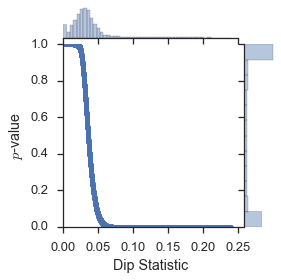

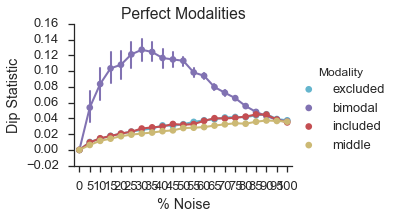

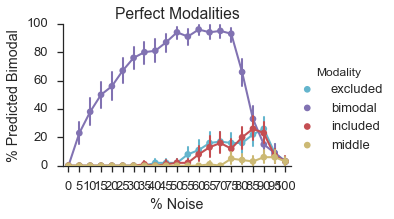

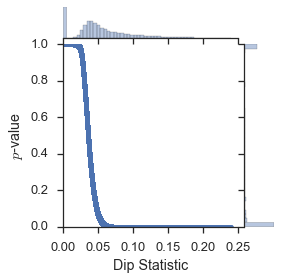

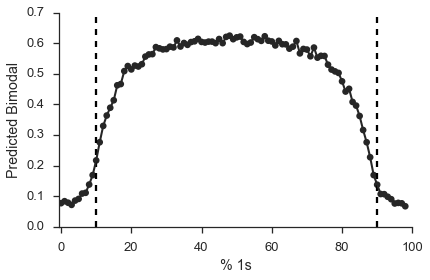

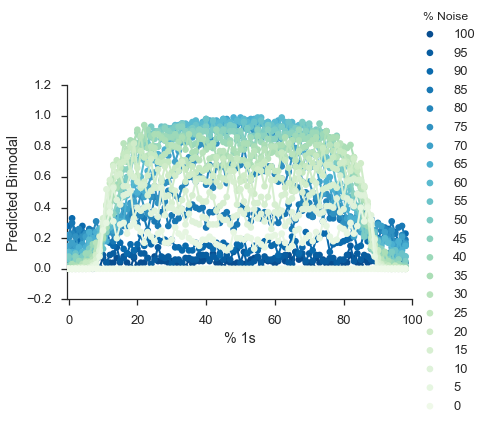

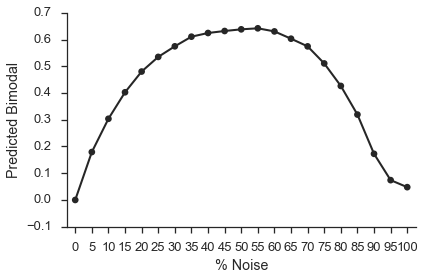

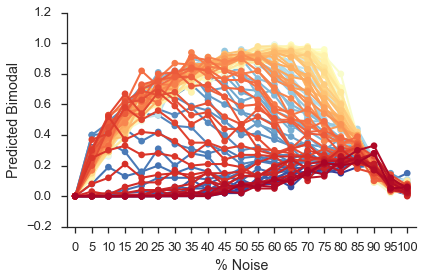

In [4]:

import six

six.moves.range?

from diptest.diptest import diptest

for name, datas in datasets.items():
    dataset_folder = '{}/{}'.format(folder, name.lower().replace(' ', '_'))
    data = datas['data']
    metadata = datas['metadata']
    
    diptest_results = data.apply(lambda x: diptest(x.values))
    diptest_results = diptest_results.apply(lambda x: pd.Series(x, index=['Dip Statistic', '$p$-value']))
    diptest_results['log10_p_value'] = np.log10(diptest_results['$p$-value'])

    g = sns.jointplot(x='Dip Statistic', y='$p$-value', data=diptest_results, stat_func=None, 
                  size=4, ylim=(0, 1), xlim=(0, 0.25))
    g.savefig('{}/diptest_statistic_vs_p_value.pdf'.format(dataset_folder))

    diptest_results['Predicted Bimodal'] = diptest_results['$p$-value'] < 0.05

    diptest_with_metadata = metadata.join(diptest_results)
    diptest_with_metadata.head()

    if name == 'Perfect Modalities':
        # Plot raw dipstatistic values vs noise
        g = sns.factorplot(x='% Noise', y='Dip Statistic', data=diptest_with_metadata, 
                           scale=0.5, size=3, aspect=1.5, hue='Modality', 
                           palette=MODALITY_PALETTE[:-1], hue_order=MODALITY_ORDER[:-1])
        g.set(title=name)
        g.savefig('{}/dip_statistic_in_all_modalities.pdf'.format(dataset_folder))

        # PLot how often this method predicted an event as bimodal, versus noise
        g = sns.factorplot(x='% Noise', y='Predicted Bimodal', data=diptest_with_metadata, 
                       scale=0.5, size=3, aspect=1.5, hue='Modality', 
                       palette=MODALITY_PALETTE[:-1], hue_order=MODALITY_ORDER[:-1])
        g.set(title=name)
        for ax in g.axes.flat:
            ax.set(ylim=(0, 1), ylabel='% Predicted Bimodal')
            ax.set(yticklabels=[int(100*tick) for tick in ax.get_yticks()])

        g.savefig('{}/dip_statistic_predicted_bimodal.pdf'.format(dataset_folder))
    else:
        g = sns.factorplot(x='% 1s', y='Predicted Bimodal', 
                       data=diptest_with_metadata, scale=0.5, color='#262626',
                       aspect=1.5, ci=None)
        for ax in g.axes.flat:
            ymin, ymax = ax.get_ylim()
            ax.vlines([10, 90], ymin, ymax, linestyle='--')
        g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100), ylim=(ymin, ymax))
        g.savefig('{}_bimodals_percent_predicted_bimodal.pdf'.format(dataset_folder))

        g = sns.factorplot(x='% 1s', y='Predicted Bimodal', 
                       data=diptest_with_metadata, scale=0.5, dodge=False,
                       aspect=1.5, ci=None, hue='% Noise', palette='GnBu_r', hue_order=np.arange(0, 101, 5)[::-1])
        g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100))
        # g.map_dataframe(sns.pointplot,  x='% 1s', y='Predicted Bimodal', scale=0.5, ci=None, dodge=False)
        g.savefig('{}_bimodals_percent_predicted_bimodal_with_noise.pdf'.format(dataset_folder))

        g = sns.factorplot(x='% Noise', y='Predicted Bimodal', 
                       data=diptest_with_metadata, scale=0.5, dodge=False, legend=False,
                       aspect=1.5, ci=None, color='#262626')
        # g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100))
        g.savefig('{}_bimodals_percent_predicted_bimodal_with_noise.pdf'.format(dataset_folder))

        g = sns.factorplot(x='% Noise', y='Predicted Bimodal', 
                       data=diptest_with_metadata, scale=0.5, dodge=False, legend=False,
                       aspect=1.5, ci=None, hue='% 1s', palette='RdYlBu_r', hue_order=np.arange(1, 100)[::-1])
        # g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100))
        g.savefig('{}_bimodals_percent_predicted_bimodal_with_noise_per_percent_1.pdf'.format(dataset_folder))

[array([ 0.25199714,  0.49873371,  0.57516028,  1.        ]),
 array([ 0.43026136,  0.62000665,  0.67878019,  1.        ]),
 array([ 0.60852558,  0.74127959,  0.7824001 ,  1.        ]),
 array([ 0.7867898 ,  0.86255253,  0.88602001,  1.        ]),
 array([ 0.95,  0.95,  0.95,  1.  ]),
 array([ 0.95457726,  0.76653099,  0.78032569,  1.        ]),
 array([ 0.91971827,  0.58735877,  0.61174   ,  1.        ]),
 array([ 0.88485928,  0.40818655,  0.44315432,  1.        ]),
 array([ 0.85104086,  0.23436275,  0.27960104,  1.        ])]

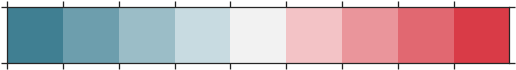

In [5]:
sns.choose_diverging_palette()

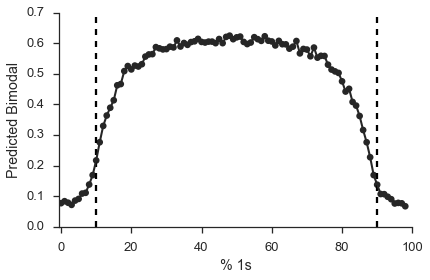

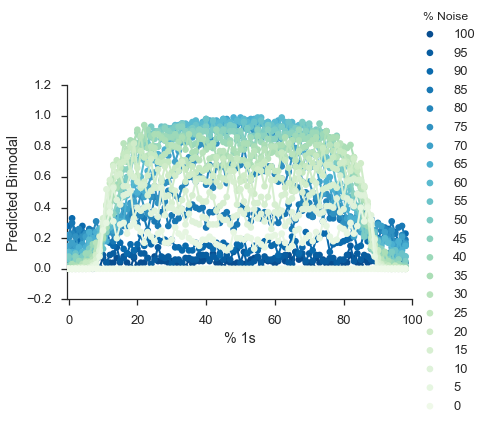

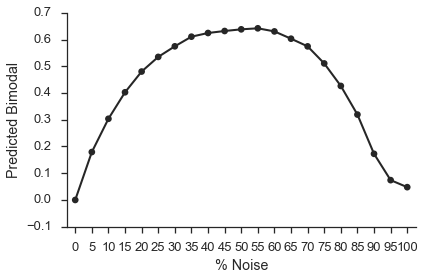

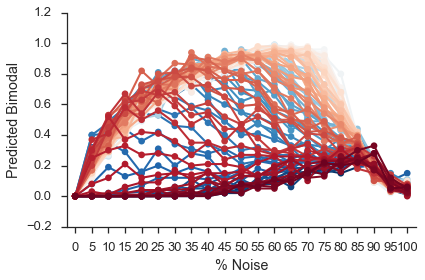

In [6]:
g = sns.factorplot(x='% 1s', y='Predicted Bimodal', 
               data=diptest_with_metadata, scale=0.5, color='#262626',
               aspect=1.5, ci=None)
for ax in g.axes.flat:
    ymin, ymax = ax.get_ylim()
    ax.vlines([10, 90], ymin, ymax, linestyle='--')
g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100), ylim=(ymin, ymax))
g.savefig('{}/bimodals_percent_predicted_bimodal.pdf'.format(dataset_folder))

g = sns.factorplot(x='% 1s', y='Predicted Bimodal', 
               data=diptest_with_metadata, scale=0.5, dodge=False,
               aspect=1.5, ci=None, hue='% Noise', palette='GnBu_r', hue_order=np.arange(0, 101, 5)[::-1])
g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100))
# g.map_dataframe(sns.pointplot,  x='% 1s', y='Predicted Bimodal', scale=0.5, ci=None, dodge=False)
g.savefig('{}/bimodals_percent_predicted_bimodal_with_noise.pdf'.format(dataset_folder))

g = sns.factorplot(x='% Noise', y='Predicted Bimodal', 
               data=diptest_with_metadata, scale=0.5, dodge=False, legend=False,
               aspect=1.5, ci=None, color='#262626')
# g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100))
g.savefig('{}/bimodals_percent_predicted_bimodal_with_noise.pdf'.format(dataset_folder))

g = sns.factorplot(x='% Noise', y='Predicted Bimodal', 
               data=diptest_with_metadata, scale=0.5, dodge=False, legend=False,
               aspect=1.5, ci=None, hue='% 1s', palette='RdBu_r', hue_order=np.arange(1, 100)[::-1])
# g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100))
g.savefig('{}/bimodals_percent_predicted_bimodal_with_noise_per_percent_1.pdf'.format(dataset_folder))

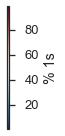

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(1, 2))
cmap = mpl.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=1, vmax=99)
mpl.colorbar.ColorbarBase(ax, cmap=cmap, label='% 1s', norm=norm, ticks=[0, 20, 40, 60, 80, 100])
fig.tight_layout()
fig.savefig('maybe_bimodals_percent_ones_colorbar_cmap.pdf')

In [8]:
diptest_with_metadata.head()

,Sample ID,$\Psi$,Iteration,% Noise,% 1s,Dip Statistic,$p$-value,log10_p_value,Predicted Bimodal
Feature ID,,,,,,,,,
bimodal_01_noise0_iter0,0,0,0,0,1,0.005,1,0,False
bimodal_02_noise0_iter0,0,0,0,0,2,0.000,1,0,False
bimodal_03_noise0_iter0,0,0,0,0,3,0.000,1,0,False
bimodal_04_noise0_iter0,0,0,0,0,4,0.000,1,0,False
bimodal_05_noise0_iter0,0,0,0,0,5,0.000,1,0,False


In [9]:
metadata.head()

,Sample ID,$\Psi$,Iteration,% Noise,% 1s
Feature ID,,,,,
bimodal_01_noise0_iter0,0,0,0,0,1
bimodal_02_noise0_iter0,0,0,0,0,2
bimodal_03_noise0_iter0,0,0,0,0,3
bimodal_04_noise0_iter0,0,0,0,0,4
bimodal_05_noise0_iter0,0,0,0,0,5


In [10]:
diptest_with_predicted = bayesian_predictions.join(diptest_results, on='Feature ID')
diptest_with_predicted.head()

NameError: name 'bayesian_predictions' is not defined

In [ ]:
g = sns.factorplot(x='% Noise', y='Dip Statistic', data=diptest_with_predicted, 
                   scale=0.5, size=3, aspect=1.5, hue='Original Modality', 
                   palette=MODALITY_PALETTE[:-1], hue_order=MODALITY_ORDER[:-1])
g.set(title='Diptest')
for ax in g.axes.flat:
    ax.set(yticks=[0, 0.04, .08, 0.12, 0.16])
g.savefig('{}/dip_statistic.pdf'.format(dataset_folder))

In [ ]:
g = sns.factorplot(x='% Noise', y='Predicted Bimodal', data=diptest_with_predicted, 
                   scale=0.5, size=3, aspect=1.5, hue='Original Modality', 
                   palette=MODALITY_PALETTE[:-1], hue_order=MODALITY_ORDER[:-1])
g.set(title='Diptest')
for ax in g.axes.flat:
    ax.set(ylim=(0, 1), ylabel='% Predicted Bimodal')
    ax.set(yticklabels=[int(100*tick) for tick in ax.get_yticks()])

g.savefig('{}/dip_statistic_predicted_bimodal.pdf'.format(dataset_folder))